<a href="https://colab.research.google.com/github/GitMechub/MecHub_CAD/blob/main/MecHub_CAD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**MecHub_CAD - v2.0.0**

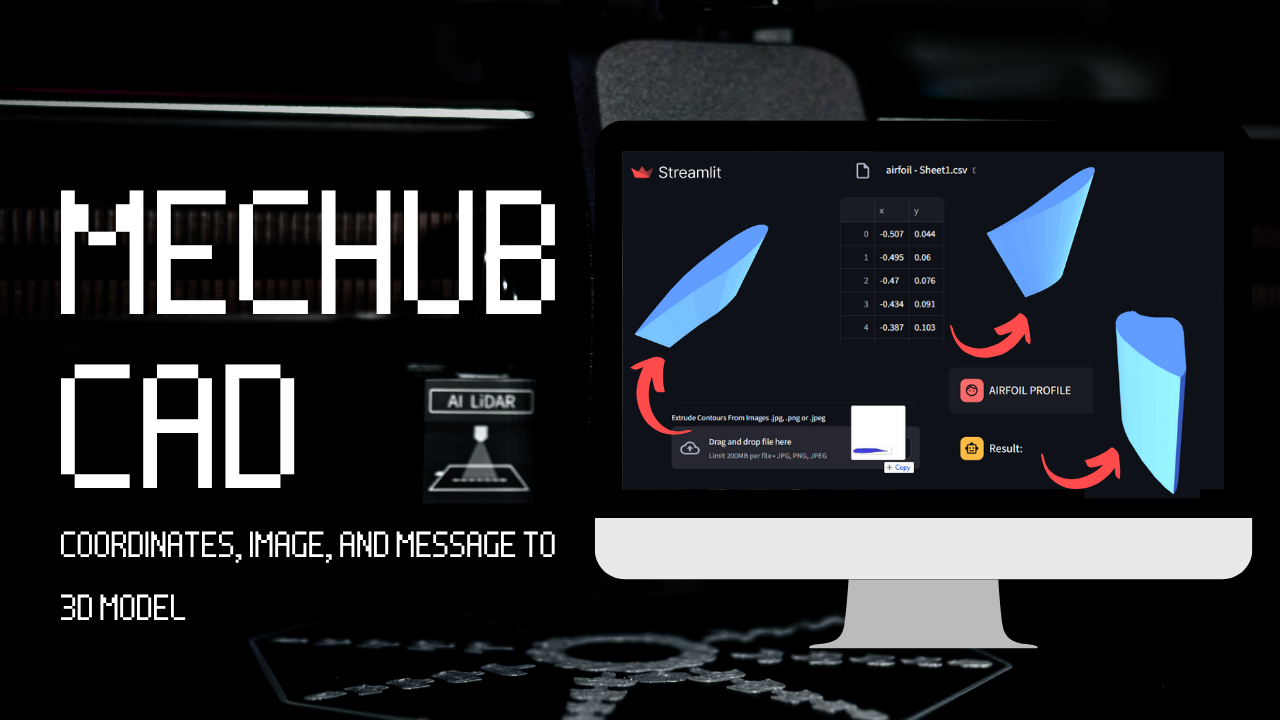

Please, subscribe to the channel [MecHub](https://youtube.com/@Mechub?sub_confirmation=1)
and check my [GitHub](https://github.com/GitMechub)

---

*Por favor, inscreva-se no canal: [MecHub](https://youtube.com/@Mechub?sub_confirmation=1) e visite o meu [GitHub](https://github.com/GitMechub)*

# PACKS

In [1]:
pip install pyvista

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 10.3 MB/s eta 0:00:00


In [2]:
pip install XlsxWriter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.4/169.4 kB 3.1 MB/s eta 0:00:00


In [3]:
pip install cadquery --use-deprecated=legacy-resolver

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.9/163.9 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.0/143.0 MB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 68.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 436.8/436.8 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.3/77.3 MB 9.9 MB/s eta 0:00:00


In [13]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cadquery as cq
from cadquery import exporters

import pyvista as pv
import plotly.graph_objects as go

import os  # Required to check if the file exists
from os import listdir
from os.path import isfile, join

import cv2  #OpenCV

from google import genai

from google.genai import types
from PIL import Image
from io import BytesIO

## FUNCTIONS

### Display CAD

In [5]:
def displayCAD(file_, title_):

  # Carregar arquivo CAD (pode ser .stl, .step, .vtk, etc.)
  filename = file_  # Altere o formato do arquivo
  mesh = pv.read(filename)

  # Obter vértices e faces da malha
  x, y, z = mesh.points.T
  faces = mesh.faces.reshape(-1, 4)[:, 1:]

  # Criar visualização interativa com Plotly
  fig = go.Figure(data=[go.Mesh3d(
      x=x, y=y, z=z,
      i=faces[:, 0], j=faces[:, 1], k=faces[:, 2],
      color='lightblue', opacity=0.5
  )])

  fig.update_layout(scene=dict(aspectmode='data'), title=title_)
  fig.show()

### Read .xlsx and .csv

In [6]:
def process_coord_files(mypath='/content'):

    # List all files in the directory
    onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

    # Store processed files and their data

    for file_ in onlyfiles:
      file_path = join(mypath, file_)
      try:
        if file_.endswith('.xlsx'):
          print(f'Reading {file_path} ...')
          excel_data = pd.read_excel(file_path, sheet_name=None)  # Load all sheets
          _sheet = list(excel_data.keys())[0]

          df = excel_data[_sheet]

          if isinstance(list(df.columns)[0], str):
            df = df.rename(columns={list(df.columns)[0]: 'x', list(df.columns)[1]: 'y'})
          elif isinstance(list(df.columns)[0], (int, float)):
            df_part1 = pd.DataFrame({'x': [list(df.columns)[0]], 'y': [list(df.columns)[1]]})  # Linha que veio como nomes das colunas
            df_part2 = df.iloc[0:]  # Linhas após a posição 0
            df_part2 = df_part2.rename(columns={list(df.columns)[0]: 'x', list(df.columns)[1]: 'y'})
            df = pd.concat([pd.DataFrame(df_part1), df_part2], ignore_index=True)

          df = df.dropna().reset_index(drop=True)

          pontos = [
              (round(df['x'][i],6), round(df['y'][i],6))
              for i in range(len(df['x']))]

          break

        elif file_.endswith('.csv'):
          csv_data = pd.read_csv(file_path)

          df = csv_data

          try:
            column_data = float(list(df.columns)[0])
          except:
            column_data = list(df.columns)[0]
            pass

          if isinstance(column_data, str):
            df = df.rename(columns={list(df.columns)[0]: 'x', list(df.columns)[1]: 'y'})
          elif isinstance(column_data, (int, float)):
            df_part1 = pd.DataFrame({'x': [list(df.columns)[0]], 'y': [list(df.columns)[1]]})  # Linha que veio como nomes das colunas
            df_part2 = df.iloc[0:]  # Linhas após a posição 0
            df_part2 = df_part2.rename(columns={list(df.columns)[0]: 'x', list(df.columns)[1]: 'y'})
            df = pd.concat([pd.DataFrame(df_part1), df_part2], ignore_index=True)

          df = df.dropna().reset_index(drop=True)

          pontos = [
              (round(float(df['x'][i]), 6), round(float(df['y'][i]), 6))
              for i in range(len(df['x']))
          ]

          break

      except:
        print(f"Error processing {file_}: {Exception}")
    return df, pontos

### Processing "EXTRUDE GEOMETRY" Input

In [7]:
# * Processing "EXTRUDE GEOMETRY" Input:

def proc_EG_input(coordinates, extrusion_type, length, revolve_angle):

  revolve_axis = (0, 1, 0)  # * v1.0.0

  if isinstance(revolve_axis, tuple):
    revolve_axis = revolve_axis
  else:
    if revolve_axis.lower() == "x":
      revolve_axis = (1, 0, 0)
    elif revolve_axis.lower() == "y":
      revolve_axis = (0, 1, 0)
    elif revolve_axis.lower() == "z":
      revolve_axis = (0, 0, 1)
    else:
      revolve_axis = (0, 1, 0)

  if extrusion_type.lower() == "basic":
      extrusion_type = "basic"
  elif extrusion_type.lower() == "revolve":
      extrusion_type = "revolve"
  elif extrusion_type.lower() == "twist":
      extrusion_type = "twist"
  else:
      extrusion_type = "basic"

  if revolve_angle > 360:
    revolve_angle = 360
  elif revolve_angle < 0:
    revolve_angle = 0


  # Rounding a list of tuples
  ## Convert the list of tuples into a NumPy array
  coordinates = np.array(coordinates)
  ## Round all values in the array to 4 decimal places
  coordinates = np.round(coordinates, 4)
  ## Convert the rounded array back to a list of tuples directly using NumPy
  coordinates = list(map(tuple, coordinates))


  # Removing consecutive duplicate tuples
  ## Convert the list of tuples into a NumPy array
  coordinates_array = np.array(coordinates)
  ## Find the indices where consecutive rows are different
  unique_indices = np.any(coordinates_array[1:] != coordinates_array[:-1], axis=1)
  ## Include the first coordinate by prepending True
  unique_indices = np.insert(unique_indices, 0, True)
  ## Select only the unique rows
  unique_coordinates = coordinates_array[unique_indices]
  ## Convert back to a list of tuples if needed
  coordinates = list(map(tuple, unique_coordinates))

  # Remove last point if it's the same as the first (for Sketch compatibility)
  if len(coordinates) > 1 and coordinates[0] == coordinates[-1]:
      coordinates = coordinates[:-1]

  return coordinates, extrusion_type, length, revolve_angle, revolve_axis


# * Function to check and reorder points to a consistent clockwise order

def reorder_clockwise(points):
    points = np.array(points)
    center = points.mean(axis=0)  # Calculate centroid
    angles = np.arctan2(points[:, 1] - center[1], points[:, 0] - center[0])
    sorted_indices = np.argsort(angles)
    coordinates = points[sorted_indices].tolist()
    coordinates = list(map(tuple, coordinates))
    return coordinates

In [8]:
def centralizar_contorno(contorno):
    if not contorno:
        return []

    x_coords, y_coords = zip(*contorno)
    x_centro = (max(x_coords) + min(x_coords)) / 2
    y_centro = (max(y_coords) + min(y_coords)) / 2

    contorno_centralizado = [(x - x_centro, y - y_centro) for (x, y) in contorno]
    return contorno_centralizado

def revolve_centralize_y(contour):
  novo_contorno = []

  for i in range(len(contour) - 1):
    p1 = contour[i]
    p2 = contour[i + 1]

    if p1[0] >= 0:
      novo_contorno.append(p1)

    if (p1[0] < 0 and p2[0] > 0) or (p1[0] > 0 and p2[0] < 0):
      x1, y1 = p1
      x2, y2 = p2
      t = -x1 / (x2 - x1)
      y_intersec = y1 + t * (y2 - y1)
      novo_contorno.append((0, y_intersec))

  # Último ponto
  if contour[-1][0] >= 0:
      novo_contorno.append(contour[-1])

  return novo_contorno

In [9]:
def offset_polygon(coordinates, offset):
    """
    Aplica um offset manual em um polígono.

    Args:
        coordinates (list of tuple): Lista de coordenadas do polígono [(x1, y1), (x2, y2), ...].
        offset (float): Distância do deslocamento (positivo para fora, negativo para dentro).

    Returns:
        list of tuple: Coordenadas do novo polígono com o offset aplicado.
    """
    def normalize(v):
        """Normaliza um vetor."""
        norm = np.sqrt(v[0]**2 + v[1]**2)
        return v / norm if norm != 0 else v

    new_coords = []
    n = len(coordinates)

    for i in range(n):
        # Pontos atual, anterior e próximo
        p1 = np.array(coordinates[i - 1])  # Ponto anterior
        p2 = np.array(coordinates[i])      # Ponto atual
        p3 = np.array(coordinates[(i + 1) % n])  # Próximo ponto

        # Vetores dos segmentos
        v1 = p2 - p1  # Vetor do segmento anterior
        v2 = p3 - p2  # Vetor do próximo segmento

        # Normais (90 graus no sentido anti-horário)
        n1 = normalize(np.array([-v1[1], v1[0]]))
        n2 = normalize(np.array([-v2[1], v2[0]]))

        # Soma das normais, normalizada
        offset_dir = normalize(n1 + n2)

        # Ajuste do ângulo para evitar deformações
        angle_cos = np.dot(n1, offset_dir)
        if angle_cos != 0:
            offset_dir /= angle_cos

        # Novo ponto deslocado
        new_point = p2 + offset_dir * offset
        new_coords.append(tuple(new_point))

    return new_coords

### Contour from Image

In [18]:
def img_contour(img_name, contours_to_remove):

  img_color = cv2.imread(img_name, cv2.IMREAD_COLOR)
  img_gray = cv2.imread(img_name, cv2.IMREAD_GRAYSCALE)

  corner_pixel = img_gray[0, 0]  # Coordenada (0, 0) para o canto superior esquerdo
  #print(f"Intensidade do pixel no canto superior esquerdo: {corner_pixel}")
  if corner_pixel > 50:
    img_gray = cv2.bitwise_not(img_gray)


  # Converting the grayscale image to binary (black and white only image).
  _, threshold = cv2.threshold(img_gray, 110, 255, cv2.THRESH_BINARY)

  # Detecting external contours in the binary image.
  contours, _ = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


  contour_coordinates = []

  for i, contour in enumerate(contours):
      cv2.drawContours(img_gray, [contour], -1, (0, 255, 0), 2)  # Green color for the contour
      #cv2.drawContours(img_color, [contour], -1, (0, 255, 0), 2)  # Green color for the contour
      contour_points = []
      for point in contour:
          x, y = point[0]  # Extracting x and y coordinates
          contour_points.append((int(x), int(y)))  # Convert to Python int
      contour_coordinates.append(contour_points)  # Add points of this contour to the list


  contour_coordinates_ = remove_contours(contour_coordinates, contours_to_remove) # Remove os contornos da lista

  return contour_coordinates_

In [19]:
def img_contour_smoother(img_name, contours_to_remove):

  img_color = cv2.imread(img_name, cv2.IMREAD_COLOR)
  img_gray = cv2.imread(img_name, cv2.IMREAD_GRAYSCALE)

  corner_pixel = img_gray[0, 0]  # Coordenada (0, 0) para o canto superior esquerdo
  #print(f"Intensidade do pixel no canto superior esquerdo: {corner_pixel}")
  if corner_pixel > 50:
    img_gray = cv2.bitwise_not(img_gray)


  # Converting the grayscale image to binary (black and white only image).
  _, threshold = cv2.threshold(img_gray, 110, 255, cv2.THRESH_BINARY)

  # Detecting external contours in the binary image.
  contours, _ = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


  # Lista para armazenar as coordenadas suavizadas
  contour_coordinates = []

  # Processar os contornos
  for i, contour in enumerate(contours):
      # Suavizar o contorno usando approxPolyDP
      peri = cv2.arcLength(contour, True)
      smoothed_contour = cv2.approxPolyDP(contour, 0.001 * peri, True)

      # Adicionar as coordenadas suavizadas à lista
      contour_points = []
      for point in smoothed_contour:
          x, y = point[0]  # Extrair as coordenadas x e y
          contour_points.append((int(x), int(y)))  # Armazenar como inteiros
      contour_coordinates.append(contour_points)

  contour_coordinates_ = remove_contours(contour_coordinates, contours_to_remove) # Remove os contornos da lista

  return contour_coordinates_


In [10]:
def plot_contour(contour_id, contours):
    if contour_id < 0 or contour_id >= len(contours):
        print(f"Contour {contour_id} not found. Valid range is 0 to {len(contours)-1}.")
        return

    # Get the specific contour coordinates
    contour = contours[contour_id]

    # Extract x and y coordinates separately
    x_coords = [point[0] for point in contour]
    y_coords = [point[1] for point in contour]

    # Create the plot
    plt.figure(figsize=(10, 10))

    # Choose a color for the contour
    colors = ['r', 'g', 'b', 'c', 'm', 'orange', 'k']
    color = colors[contour_id % len(colors)]

    # Plot the contour
    plt.plot(x_coords, y_coords, color=color, marker='o', linestyle='-')

    plt.title(f'Contour {contour_id}, Points={len(contour)}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.axis('equal')

    # Show the plot
    plt.gca().invert_yaxis()
    plt.show()


def plot_all_contours(contours):
    plt.figure(figsize=(10, 10))

    colors = ['r', 'g', 'b', 'c', 'm', 'orange', 'k']  # Define a palette of colors

    for contour_id, contour in enumerate(contours):
      try:
        # Extract x and y coordinates separately
        x_coords = [point[0] for point in contour]
        y_coords = [point[1] for point in contour]

        # Choose a color for the contour
        color = colors[contour_id % len(colors)]

        # Plot the contour on the same graph
        plt.plot(x_coords, y_coords, color=color, marker='o', linestyle='-', label=f'Contour {contour_id}, Points={len(contour)}')
      except:
        pass

    # Adding labels, grid, and legend
    plt.title('All Contours')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.axis('equal')
    plt.legend(loc='upper right')  # Add a legend to identify each contour

    # Show the plot
    plt.gca().invert_yaxis()
    plt.show()


def plot_all_contours_closed(contours):
    plt.figure(figsize=(10, 10))

    colors = ['r', 'g', 'b', 'c', 'm', 'orange', 'k']  # Define a palette of colors

    for contour_id, contour in enumerate(contours):
      try:
        # Extract x and y coordinates separately
        x_coords = [point[0] for point in contour]
        y_coords = [point[1] for point in contour]

        # Add the first point to the end to close the contour
        x_coords.append(x_coords[0])
        y_coords.append(y_coords[0])

        # Choose a color for the contour
        color = colors[contour_id % len(colors)]

        # Plot the contour on the same graph
        plt.gca().invert_yaxis()
        plt.plot(x_coords, y_coords, color=color, marker='o', linestyle='-', label=f'Contour {contour_id}, Points={len(contour)}')
      except:
        pass

    # Adding labels, grid, and legend
    plt.title('All Contours')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.axis('equal')
    plt.legend(loc='upper right')  # Add a legend to identify each contour

    # Show the plot
    plt.gca().invert_yaxis()
    plt.show()


def remove_contours(contour_coordinates, contours_to_remove):
    # Converte contours_to_remove para um conjunto para verificações mais rápidas
    indices_a_remover = set(contours_to_remove)

    # Substitui os índices a remover por None
    lista_resultante = [item if i not in indices_a_remover else None for i, item in enumerate(contour_coordinates)]
    return lista_resultante

In [11]:
def scale_contour(contour, scale):
  contour = np.array(contour, dtype=np.float64)  # Garantir que é um array NumPy
  center = contour.mean(axis=0)  # Encontrar o centro do contorno
  scaled_contour = (contour - center) * scale + center  # Escalar em relação ao centro
  #return [(round(point[0],4), round(point[1],4)) for point in scaled_contour]  # Retornar como lista de tuplas
  return [(point[0],point[1]) for point in scaled_contour]  # Retornar como lista de tuplas

In [12]:
def centralizar_conjunto_de_contornos(contornos):
    if not contornos:
        return []

    # Remover contornos que são None ou vazios
    contornos_validos = [contorno for contorno in contornos if contorno]

    if not contornos_validos:
        return []

    contornos = contornos_validos

    todos_os_pontos = [p for contorno in contornos for p in contorno]
    x_coords, y_coords = zip(*todos_os_pontos)
    x_centro = (max(x_coords) + min(x_coords)) / 2
    y_centro = (max(y_coords) + min(y_coords)) / 2

    contornos_centralizados = [
        [(x - x_centro, y - y_centro) for (x, y) in contorno]
        for contorno in contornos
    ]
    return contornos_centralizados


def revolve_centralize_y_multiple(contours):
  contornos_processados = []

  for contour in contours:
    novo_contorno = []

    for i in range(len(contour) - 1):
      p1 = contour[i]
      p2 = contour[i + 1]

      if p1[0] >= 0:
        novo_contorno.append(p1)

      if (p1[0] < 0 and p2[0] > 0) or (p1[0] > 0 and p2[0] < 0):
        x1, y1 = p1
        x2, y2 = p2
        t = -x1 / (x2 - x1)
        y_intersec = y1 + t * (y2 - y1)
        novo_contorno.append((0, y_intersec))

    # Último ponto
    if contour[-1][0] >= 0:
        novo_contorno.append(contour[-1])

    contornos_processados.append(novo_contorno)

  return contornos_processados

# OPTIONS



*   Extrude Geometry from Coordinates: Set them manually or using a .xlsx or .csv file. Please check 'UPLOADING A COORDINATES FILE'.
*   Extrude Geometry from .jpg or .png Image.
*   ***NEW:*** Extrude Geometry from AI Prompt: 3D model generated by AI based on your description (via Google Gemini).



# EXTRUDE GEOMETRY FROM COORDINATES

Set the geometry coordinates and extrude it by revolving through an axis or by basic extrusion. You can do it manually or by uploading an .xlsx sheet with both "x" (Column A) and "y" (Column B) columns

## UPLOADING A COORDINATES FILE (EXAMPLE)


*   The file must be saved in either .xlsx or .csv format.
*   For .xlsx files, column A represents the x-axis, while column B represents the y-axis.
*   For .xlsx files, decimal values should use a " . " as the separator, not a " , "
*   For .csv files, the first value represents the x-axis and the second value represents the y-axis.

* **Coordinates in both formats must be in order, with each (x,y) point located between the previous and next points.**



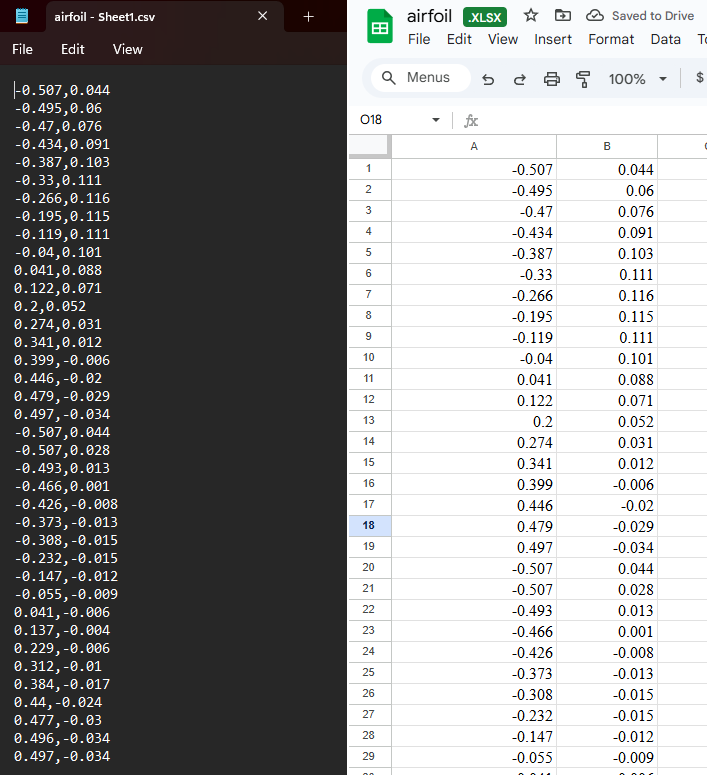

## INPUT

Ctrl + F9 to Execute All

In [51]:
#** INPUT: **


# Coordinates:
## Points must be listed in sequential order, where each point connects to the previous one.
## For example, the second point connects to the first, and the third connects to the second.

## Example: coordinates = [(0, 0), (0, 4), (4, 4), (4, 0)]
## This creates a square with a height and width of 4 units

coordinates = [(0, 0), (0, 4), (4, 4), (4, 0)]

# If you prefer to upload a file instead of setting the coordinates manually -> True. Please check 'UPLOADING A COORDINATES FILE'.
## The points must be ordered
upload_coordinates = False  # Options: True or False | Default = False

# Extrusion type: choose between "basic", "revolve" or "twist" (default = "basic")
extrusion_type = "basic"

# Parameters for "basic extrusion":
length = 4  # Extrusion length (for basic extrusion)

# Parameters for "revolve extrusion" (revolve axis = "y"):
revolve_angle = 360  # Revolve angle in degrees (default = 360 ° for a full revolution)
centralize = False  # Rotate around the center of the object (True or False) | Default = False

## Parameters for "twist extrusion":
twist_length = 4
twist_angle = 30
###


#** OPTIONAL (SET True OR False): **

# EXTRUDED CUT:

## If you want to perform an Extruded Cut (Optional), change the option below to True
extruded_cut = True    # Options: True or False | Default = False

## Coordinates:
### Points must be listed in sequential order, where each point connects to the previous one.
### For example, the second point connects to the first, and the third connects to the second.

### Example: coordinates = [(1, 1), (1, 3), (3, 3), (3, 1)]
### This CUTS a square with a height and width of 2 units

coordinates_cut = [(1, 1), (1, 3), (3, 3), (3, 1)]  # XY-plane points defining the sketch geometry

## Parameters for "basic extrusion":
length_cut = 6  # Extrusion cut length

## Parameters for "revolve extrusion" (revolve axis = "y"):
revolve_angle_cut = 360  # Revolve angle in degrees (default = 360 ° for a full revolution)

## Parameters for "twist extrusion":
twist_length_cut = 4
twist_angle_cut = 30
###


# SET SCALE

## This option allows you to adjust the scale of the drawing contour that has been set.
set_scale = False    # Options: True or False | Default = False
scale = 2  # Define the scale

###


#****


## CODE

In [52]:
if upload_coordinates is True:
  df_uploaded_points, uploaded_points = process_coord_files()
  coordinates = uploaded_points


centralize_cut = centralize

coordinates, extrusion_type, length, revolve_angle, revolve_axis = proc_EG_input(coordinates, extrusion_type, length, revolve_angle)
extrusion_type_cut = extrusion_type
coordinates_cut, extrusion_type_cut, length_cut, revolve_angle_cut, revolve_axis_cut = proc_EG_input(coordinates_cut, extrusion_type_cut, length_cut, revolve_angle_cut)


if extrusion_type == "revolve" and centralize:
    coordinates = centralizar_contorno(coordinates)
    coordinates = revolve_centralize_y(coordinates)
elif extrusion_type == "twist":
    coordinates = centralizar_contorno(coordinates)

try:
    if extrusion_type == "revolve" and centralize_cut:
        coordinates_cut = centralizar_contorno(coordinates_cut)
        coordinates_cut = revolve_centralize_y(coordinates_cut)
    elif extrusion_type == "twist":
        coordinates_cut = centralizar_contorno(coordinates_cut)
except:
    pass

coordinates

[(np.float64(-2.0), np.float64(-2.0)),
 (np.float64(-2.0), np.float64(2.0)),
 (np.float64(2.0), np.float64(2.0)),
 (np.float64(2.0), np.float64(-2.0))]

In [53]:
def extruded_cut_geometry(coordinates_cut, coordinates, solid, s_surface, length_cut, twist_length_cut, twist_angle_cut,
                                          extrusion_type_cut="basic", revolve_angle_cut=360, revolve_angle=360,
                                          revolve_axis_cut=(0, 1, 0), extruded_cut=False, set_scale=False, scale=1):

  if os.path.exists('final_sketch_MHCAD_cut.stl'):
      os.remove('final_sketch_MHCAD_cut.stl')
      print(f"Existing file 'final_sketch_MHCAD_cut.stl' removed.")

  if os.path.exists('final_solid_MHCAD_cut.stl'):
      os.remove('final_solid_MHCAD_cut.stl')
      print(f"Existing file 'final_solid_MHCAD_cut.stl' removed.")

  if extruded_cut is True:
    try:

      # Sketch

      ## Add segments between the points
      sketch = cq.Sketch()

      try:
        for i in range(len(coordinates_cut) - 1):
            sketch = sketch.segment(coordinates_cut[i], coordinates_cut[i + 1])
      except:   # Trying to reorder if error
        coordinates_cut = reorder_clockwise(coordinates_cut)
        for i in range(len(coordinates_cut) - 1):
            sketch = sketch.segment(coordinates_cut[i], coordinates_cut[i + 1])

        ### If the coordinates for the extrude cut are the same as those for the solid
        if coordinates_cut == coordinates and extruded_cut == True:
            print("Error: The coordinates for the extrude cut are the same as those for the solid")
            extruded_cut = False
            return 'sketch_MHCAD.stl', 'solid_MHCAD.stl'

      ## Close the sketch, if necessary
      s_surface_cut = sketch.close().assemble(tag="face_")

      if set_scale is True:
        try:
          s_surface_cut = s_surface_cut.val().scale(scale)
        except:
          print("Error during scaling - Extruded cut")
          pass

      ## Result (Sketch)
      result_sketch = s_surface - s_surface_cut

      ## Export as STL
      sketch_name = 'final_sketch_MHCAD_cut.stl'
      exporters.export(result_sketch, sketch_name)

      # 3D

      ## Create the sketch in CadQuery
      profile = [(x, y) for x, y in coordinates_cut]  # Swap to (r, z) for the XY plane
      #sketch = cq.Workplane("XY").polyline(profile).close()  # Close the profile

      sketch = cq.Workplane("XY").placeSketch(s_surface_cut)

      if set_scale is True:
        length_cut = length_cut * scale
        twist_length_cut = twist_length_cut * scale

      ## Extrude or Revolve around the axis (Y is the default axis for revolve!)
      solid_cut = sketch.revolve(angleDegrees=revolve_angle_cut, axisStart=(0, 0, 0),
                                  axisEnd=revolve_axis_cut) if extrusion_type_cut == "revolve" else sketch.twistExtrude(
          twist_length_cut, twist_angle_cut) if extrusion_type_cut == "twist" else sketch.extrude(length_cut)

      solid = solid.cut(solid_cut)

      ## Export as STL
      solid_name = 'final_solid_MHCAD_cut.stl'
      exporters.export(solid, solid_name)

      return sketch_name, solid_name

    except:
      print("Error: Extruded Cut")
      return 'sketch_MHCAD.stl', 'solid_MHCAD.stl'

  else:
      return 'sketch_MHCAD.stl', 'solid_MHCAD.stl'


In [54]:
def create_and_export_sketch(coordinates, set_scale, scale, filename='sketch_MHCAD.stl'):

    def attempt_sketch(coords, set_scale=False, scale=1):

        try:
            sketch = cq.Sketch()
            for i in range(len(coords) - 1):
                sketch = sketch.segment(coords[i], coords[i + 1])
            s_surface = sketch.close().assemble(tag="face")
            if set_scale is True:
              try:
                s_surface = s_surface.val().scale(scale)
              except:
                print("Error during scaling")
                pass
            exporters.export(s_surface, filename)
            if os.path.exists(filename):
                return s_surface
            return None
        except Exception as e:
            print(f"Error during sketch attempt: {e}")
            return None

    # Step 1: Remove the file if it already exists
    if os.path.exists(filename):
        try:
            os.remove(filename)
            print(f"Existing file '{filename}' removed.")
        except Exception as e:
            print(f"Error removing file '{filename}': {e}")
            return coordinates, None  # Return original coordinates if cleanup fails

    # Attempt 1: Use the original coordinates
    print("Attempting to create sketch with original coordinates...")
    s_surface = attempt_sketch(coordinates, set_scale, scale)
    if s_surface:
        print("File successfully created on the first attempt!")
        return coordinates, s_surface

    # Attempt 2: Reorder the coordinates clockwise
    try:
        print("Reordering coordinates clockwise and retrying...")
        coordinates_reordered = reorder_clockwise(coordinates)
        s_surface = attempt_sketch(coordinates_reordered, set_scale, scale)
        if s_surface:
            print("File successfully created after reordering!")
            return coordinates_reordered, s_surface
    except Exception as e:
        print(f"Reordering failed: {e}")

    # Attempt 3: Adjust coordinates by adding (0,0) and the last x-value point
    try:
        print("Adjusting coordinates by adding (0,0) and the last x-value...")
        coordinates.insert(0, (0, 0))
        coordinates.append((coordinates[-1][0], 0))  # Use x-value of the last point
        coordinates_reordered = reorder_clockwise(coordinates)
        s_surface = attempt_sketch(coordinates_reordered, set_scale, scale)
        if s_surface:
            print("File successfully created after adjusting points!")
            return coordinates_reordered, s_surface
    except Exception as e:
        print(f"Adjusting points failed: {e}")

    # If all attempts fail
    print("Error: Unable to create the sketch after all attempts.")
    return coordinates, None


In [55]:
coordinates_, s_surface = create_and_export_sketch(coordinates, set_scale, scale)

# Operações opcionais no sketch final
if s_surface:
  try:
    print("Sketch creation completed. Surface generated successfully.")

    sketch = cq.Workplane("XY").placeSketch(s_surface)

    ## Create the sketch in CadQuery
    #profile = [(x, y) for x, y in coordinates]  # Swap to (r, z) for the XY plane
    #print(profile)
    #sketch = cq.Workplane("XY").polyline(profile).close()  # Close the profile'''

    if set_scale:
      length_ = length * scale
      twist_length_ = twist_length * scale
    else:
      length_ = length
      twist_length_ = twist_length

    ## Extrude or Revolve around the axis (Y is the default axis for revolve!)
    solid = sketch.revolve(angleDegrees=revolve_angle, axisStart=(0, 0, 0),
                            axisEnd=revolve_axis) if extrusion_type == "revolve" else sketch.twistExtrude(
        twist_length_, twist_angle) if extrusion_type == "twist" else sketch.extrude(length_)

    ## Export as STL
    exporters.export(solid, 'solid_MHCAD.stl')

    #displayCAD("/content/solid_MHS_CAD.stl", "Solid")


    # Extruded Cut

    sketch_name, solid_name = extruded_cut_geometry(coordinates_cut, coordinates_, solid, s_surface, length_cut, twist_length_cut, twist_angle_cut, extrusion_type_cut, revolve_angle_cut, revolve_angle, revolve_axis_cut, extruded_cut, set_scale, scale)
  except Exception as e:
    print(f"Error creating extrusion: {e}")
else:
    print("Sketch creation failed.")


Existing file 'sketch_MHCAD.stl' removed.
Attempting to create sketch with original coordinates...
File successfully created on the first attempt!
Sketch creation completed. Surface generated successfully.


## OUTPUT

In [56]:
displayCAD(f"/content/{sketch_name}", f"Sketch: {sketch_name}")

In [57]:
displayCAD(f"/content/{solid_name}", f"Solid: {solid_name}")

# EXTRUDE CONTOUR FROM IMAGE

- This app reads the external contour of images to create an extrusion.
- The image file must be in **.jpg**, **.jpeg** or **.png** format.
- The background must be **BLACK** or **WHITE**, contrasting with the image contour in the center.  
- Higher image quality leads to better contour quality.
- Fewer colors and shadows in the image produce better results.

Ctrl + F10 to Execute All

## INPUT

In [39]:
#** INPUT: **

# Extrude Contours From Images .jpg or .png

img_name = 'mechub_logo.png'   # Upload a '.jpg' or '.png' image and insert its name here (higher image quality leads to better contour quality)

contours_to_remove = []  # Optional: Include the list of contours you'd like to remove from the CAD
# Example: contours_to_remove = [0, 2]

try_smoother = True  # Options: True or False | Default = True


# Extrusion type: choose between "basic", "revolve" or "twist" (default = "basic")
extrusion_type_img = "basic"


## Parameters for "basic extrusion":
length_img = 10  # Extrusion length (for basic extrusion)

## Parameters for "revolve extrusion" (revolve axis = "y"):
revolve_angle_img = 360  # Revolve angle in degrees (default = 360 ° for a full revolution)
centralize_img = True  # Rotate around the center of the object (True or False) | Default = True

## Parameters for "twist extrusion":
twist_length_img = 10
twist_angle_img = 30

###


## CODE

In [42]:
contour_coordinates_ = img_contour(img_name, contours_to_remove) if try_smoother is False else img_contour_smoother(img_name, contours_to_remove)

if extrusion_type_img == "revolve" and centralize_img:
    contour_coordinates_ = centralizar_conjunto_de_contornos(contour_coordinates_)
    contour_coordinates_ = revolve_centralize_y_multiple(contour_coordinates_)
elif extrusion_type_img == "twist":
    contour_coordinates_ = centralizar_conjunto_de_contornos(contour_coordinates_)

result = None
modelo_combinado = None

for contour in contour_coordinates_:

  if contour is None:
    continue

  ## Criar o esboço inicial
  sketch1 = cq.Sketch()

  try:
    for i in range(len(contour) - 1):
        sketch1 = sketch1.segment(contour[i], contour[i + 1])

    sketch1 = sketch1.close().assemble(tag="face").reset()

    try:
      result = result + sketch1
    except:
      result = sketch1
  except:
    print("Error generating contour sketch")
    continue


## Exportar o modelo como STL
exporters.export(result, 'img_sketch_MHCAD.stl')


## 3D

modelo_combinado = cq.Workplane("XY").placeSketch(result).revolve(angleDegrees=revolve_angle_img,
                                                                              axisStart=(0, 0, 0),
                                                                              axisEnd=(0, 1,
                                                                                       0)) if extrusion_type_img == "revolve" else cq.Workplane(
                "XY").placeSketch(result).twistExtrude(twist_length_img,
                                                       twist_angle_img) if extrusion_type_img == "twist" else cq.Workplane(
                "XY").placeSketch(result).extrude(length_img)

### Exportar como STL
exporters.export(modelo_combinado, 'img_solid_MHCAD.stl')


Saving .xlsx coordinates file

In [43]:
# Saving a .xlsx file

file_name = 'img_contour_coordinates'
excel_writer = pd.ExcelWriter(file_name+'.xlsx', engine='xlsxwriter')


img_coord_dict = {
    i: pd.DataFrame(coords, columns=['x', 'y'])
    for i, coords in enumerate(contour_coordinates_)
}


for contour in range(len(contour_coordinates_)):

    try:
      img_coord_ = pd.DataFrame(img_coord_dict[contour])
      img_coord_.to_excel(excel_writer, sheet_name='Contour '+str(contour), index=False)
    except Exception as e:
      print(f"Error: Saving contour coordinates - {e}")
      pass

excel_writer.close()

## OUTPUT

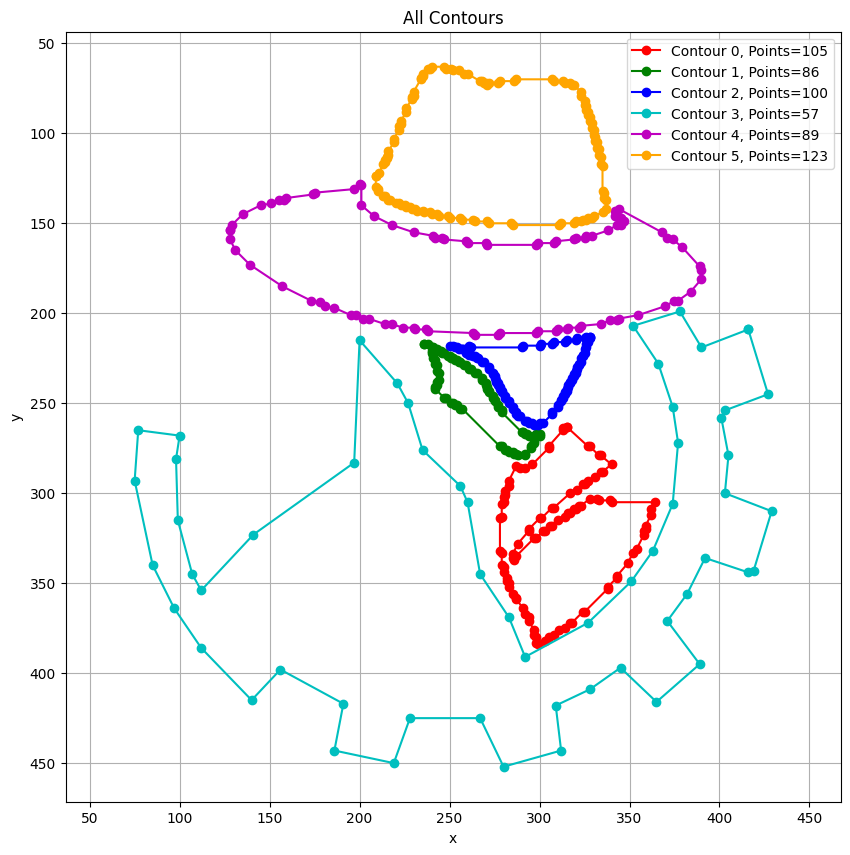

In [44]:
plot_all_contours_closed(contour_coordinates_)

In [45]:
displayCAD("/content/img_sketch_MHCAD.stl", "Sketch: img_sketch_MHCAD")
displayCAD("/content/img_solid_MHCAD.stl", "Solid: img_solid_MHCAD")

# EXTRUDE CONTOUR FROM AI PROMPT (GOOGLE GEMINI)

- This app uses Google Gemini to generate a 3D model from a text prompt.
- Simply describe the object or scene you want in clear and specific language.
- The better the prompt, the more accurate and detailed the 3D model will be.
-  If you want to use the apps above, remove your API key below to avoid any risk of credit consumption

Ctrl + F10 to Execute All (If you want to use the apps above, remove your API key below to avoid any risk of credit consumption)

## INPUT

In [16]:
#** INPUT: **

# Extrude Contours From AI Prompt (Gemini Google)

api_key = ""    # GOOGLE GEMINI API KEYS: https://aistudio.google.com/apikey

ai_prompt_object = "Chess pawn"    # What would you like to have generated


try_smoother = False  # Options: True or False | Default = False


# Extrusion type: choose between "basic", "revolve" or "twist" (default = "basic")
extrusion_type = "revolve"

## Parameters for "basic extrusion":
length = 10  # Extrusion length (for basic extrusion)

## Parameters for "revolve extrusion" (revolve axis = "y"):
revolve_angle = 360  # Revolve angle in degrees (default = 360 ° for a full revolution)
centralize = True  # Rotate around the center of the object (True or False) | Default = True

## Parameters for "twist extrusion":
twist_length = 10
twist_angle = 30


# SET SCALE

## This option allows you to adjust the scale of the drawing contour that has been set.
set_scale = False    # Options: True or False | Default = False
scale = 2  # Define the scale

###


## ONLY RUN THIS IF YOU HAVE CHANGED YOUR PROMPT

In [ ]:
user_msg = str(ai_prompt_object)

client = genai.Client(api_key=api_key)

if user_msg:
    role = "Give the contour coordinates in python needed to CadQuery draw the object"
    response = client.models.generate_content(
        model="gemini-2.0-flash-preview-image-generation",
        contents=f'A 2D silhouette of {user_msg} on a white background, perspective view, no shadows',
        config=types.GenerateContentConfig(
          response_modalities=['TEXT', 'IMAGE']
        )
    )

else:
  print("Error: No user message provided")


for part in response.candidates[0].content.parts:
    if part.text is not None:
        print(part.text)
    elif part.inline_data is not None:
        image = Image.open(BytesIO((part.inline_data.data)))
        image.save('user_msg.png')

## CODE

A stark white background will feature a solid black, 2D silhouette of a chess pawn, viewed from a slightly elevated perspective to showcase its rounded head and tiered base. There will be no shadows present, emphasizing the clean, graphic nature of the shape.



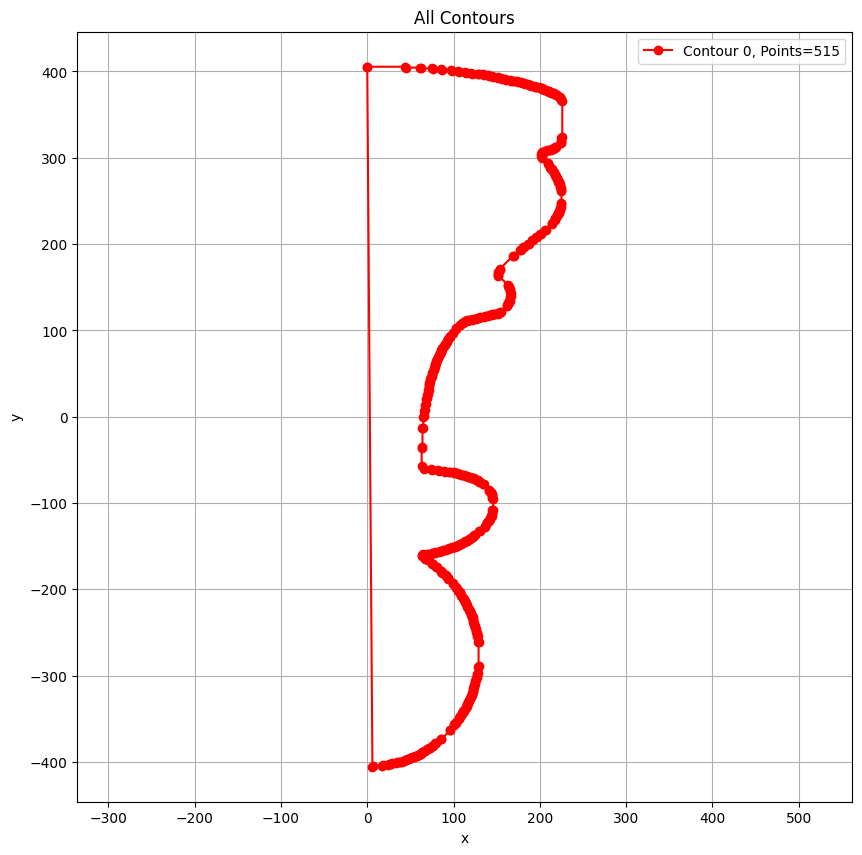

In [20]:
contour_coordinates_ = img_contour("user_msg.png", []) if try_smoother is False else img_contour_smoother("user_msg.png",[])

if extrusion_type == "revolve" and centralize:
    contour_coordinates_ = centralizar_conjunto_de_contornos(contour_coordinates_)
    contour_coordinates_ = revolve_centralize_y_multiple(contour_coordinates_)
elif extrusion_type == "twist":
    contour_coordinates_ = centralizar_conjunto_de_contornos(contour_coordinates_)


plot_all_contours_closed(contour_coordinates_)


result = None
modelo_combinado = None

for contour in contour_coordinates_:

    if contour is None:
        continue

    ## Criar o esboço inicial
    sketch1 = cq.Sketch()

    try:
        for i in range(len(contour) - 1):
            sketch1 = sketch1.segment(contour[i], contour[i + 1])

        sketch1 = sketch1.close().assemble(tag="face").reset()

        try:
            result = result + sketch1
        except:
            result = sketch1
    except:
        print("Error generating contour sketch")
        continue

## Exportar o modelo como STL
exporters.export(result, 'ai_sketch_MHCAD.stl')


## 3D
modelo_combinado = cq.Workplane("XY").placeSketch(result).revolve(angleDegrees=revolve_angle, axisStart=(0,0,0),
                        axisEnd=(0,1,0)) if extrusion_type == "revolve" else cq.Workplane("XY").placeSketch(result).twistExtrude(twist_length, twist_angle) if extrusion_type == "twist" else cq.Workplane("XY").placeSketch(result).extrude(length)


### Exportar como STL
exporters.export(modelo_combinado, 'ai_solid_MHCAD.stl')


Saving a .xlsx coordinates file

In [22]:
# Saving a .xlsx file

file_name = 'ai_contour_coordinates'
excel_writer = pd.ExcelWriter(file_name+'.xlsx', engine='xlsxwriter')


ai_coord_dict = {
    i: pd.DataFrame(coords, columns=['x', 'y'])
    for i, coords in enumerate(contour_coordinates_)
}


for contour in range(len(contour_coordinates_)):

    try:
      ai_coord_ = pd.DataFrame(ai_coord_dict[contour])
      ai_coord_.to_excel(excel_writer, sheet_name='Contour '+str(contour), index=False)
    except Exception as e:
      print(f"Error: Saving contour coordinates - {e}")
      pass

excel_writer.close()

## OUTPUT

In [21]:
displayCAD("/content/ai_sketch_MHCAD.stl", "Sketch: ai_sketch_MHCAD")
displayCAD("/content/ai_solid_MHCAD.stl", "Solid: ai_solid_MHCAD")